In [1]:
import os
import re
import time
import glob
import tables as tb
import numpy  as np
import pandas as pd

from invisible_cities.core.system_of_units import year, kg, dalton
from invisible_cities.evm.mixer import get_mixer_nevents

os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"
import zfit
import hist

%matplotlib ipympl
import matplotlib.pyplot as plt

plt.rcParams["font.size"]      = 10
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"
plt.rcParams["figure.max_open_warning"] = False

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/__init__.py:54: UserWarning: This is an ALPHA version of zfit for feature testing, do NOT use it in production! It is NOT stable and contains bugs and untested features. For production use, please use the last beta stable version of zfit.
  warnings.warn(


In [10]:
get_t12 = lambda filename: re.findall("[0-9]+[.][0-9]+e[+][0-9]+", filename)[0]

filenames = sorted(glob.glob("./results/typeI/merged_results_*.csv"))

df = pd.DataFrame()
for i, filename in enumerate(filenames, 1):
    print(f"adding {i}/{len(filenames)}", end="\r")
    df_ = pd.read_csv(filename)
    df_["T12"] = float(get_t12(filename))
    df = pd.concat([df, df_])
df.set_index("T12", inplace=True)

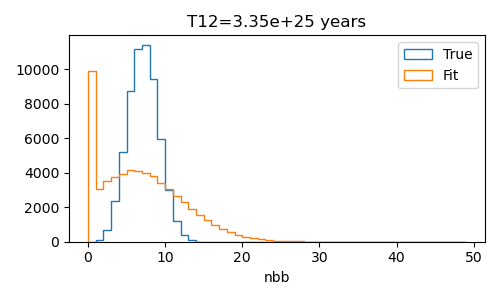

In [5]:
bins=np.arange(0, 50, 1)
density=False


# for t12, df_ in df.groupby(level=0):
#     plt.figure(figsize=[5, 3])
#     plt.title(f"T12={t12} years")
#     plt.hist(df_.nbbt, bins=bins, histtype="step", label="True", density=density)
#     plt.hist(df_.nbb , bins=bins, histtype="step", label=f"{t12}", density=density)
#     plt.xlabel("nbb")
#     plt.legend()
#     plt.tight_layout()


t12 = 3.35e25

plt.figure(figsize=[5, 3])
plt.title(f"T12={t12} years")
plt.hist(df.loc[t12].nbbt, bins=bins, histtype="step", label="True", density=density)
plt.hist(df.loc[t12].nbb , bins=bins, histtype="step", label= "Fit", density=density)
plt.xlabel("nbb")
plt.legend()
plt.tight_layout()

## Pulls

$$X = \frac{n_{\text{fit}} - n_{\text{true}}}{s(n_{\text{fit}})}$$

In [25]:
# # gaussian fit
# mu    = zfit.Parameter(   "mu", 0, -10, 10)
# sigma = zfit.Parameter("sigma", 1,   0, 10)

# obs   = zfit.Space('p', limits=(-10, 10))
# gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)
# minimizer = zfit.minimize.Minuit()

In [26]:
# for t12, df_ in df.groupby(level=0):
    
#     plt.figure(figsize=[9, 3])
#     plt.suptitle(f"T12 = {t12} years")

#     bins = np.arange(-3., 3., 0.06)

#     # 0nubb
#     plt.subplot(131)
#     p = ((df_.nbb - df_.nbbt) / df_.sbb).values
#     data = zfit.Data.from_numpy(obs=obs, array=p)
#     nll  = zfit.loss.UnbinnedNLL(model=gauss, data=data)
#     result = minimizer.minimize(nll)
#     result.hesse()

#     plt.hist(p, bins=bins, histtype="step", color="k", density=True)
#     plt.plot(bins, gauss.pdf(bins), color="r")
#     plt.annotate(r"$\mu = $"    + str(round(result.params[   "mu"]["value"], 2)), (0.05, 0.55), xycoords="axes fraction")
#     plt.annotate(r"$\sigma = $" + str(round(result.params["sigma"]["value"], 2)), (0.05, 0.45), xycoords="axes fraction")
#     plt.xlabel(r"$p_{\beta\beta}$")

#     # 208Tl
#     plt.subplot(132)
#     p = ((df_.nTl - df_.nTlt) / df_.sTl).values
#     data = zfit.Data.from_numpy(obs=obs, array=p)
#     nll  = zfit.loss.UnbinnedNLL(model=gauss, data=data)
#     result = minimizer.minimize(nll)
#     result.hesse()

#     plt.hist(p, bins=bins, histtype="step", color="k", density=True)
#     plt.plot(bins, gauss.pdf(bins), color="r")
#     plt.annotate(r"$\mu = $"    + str(round(result.params[   "mu"]["value"], 2)), (0.05, 0.55), xycoords="axes fraction")
#     plt.annotate(r"$\sigma = $" + str(round(result.params["sigma"]["value"], 2)), (0.05, 0.45), xycoords="axes fraction")
#     plt.xlabel(r"$p_{Tl}$")

#     # 214Bi
#     plt.subplot(133)
#     p = ((df_.nBi - df_.nBit) / df_.sBi).values
#     data = zfit.Data.from_numpy(obs=obs, array=p)
#     nll  = zfit.loss.UnbinnedNLL(model=gauss, data=data)
#     result = minimizer.minimize(nll)
#     result.hesse()

#     plt.hist(p, bins=bins, histtype="step", color="k", density=True)
#     plt.plot(bins, gauss.pdf(bins), color="r")
#     plt.annotate(r"$\mu = $"    + str(round(result.params[   "mu"]["value"], 2)), (0.05, 0.55), xycoords="axes fraction")
#     plt.annotate(r"$\sigma = $" + str(round(result.params["sigma"]["value"], 2)), (0.05, 0.45), xycoords="axes fraction")
#     plt.xlabel(r"$p_{Bi}$")

#     plt.tight_layout();
# #     break

## Confidence belt

$R = \frac{P(n_{\beta\beta}|T_{1/2})}{P(n_{\beta\beta}|T^{best}_{1/2})}$

In [26]:
# df = df.loc[t12s[::3]]

In [6]:
bins = np.arange(0, 40, 0.5)
binc = (bins[1:] + bins[:-1])/2.

belt = []

for t12, df_ in df.groupby(level=0):
    h, _ = np.histogram(df_.nbb, bins=bins, density=True)
    belt.append(h)
belt = np.array(belt)

In [7]:
R = belt / belt.max(axis=0)
R = R[:, ~np.isnan(R).all(axis=0)]

In [8]:
CL = 0.9

lims = []
t12s = []

for row, (t12, _) in enumerate(df.groupby(level=0)):
    b = belt[row]
    t = R   [row]
    ord_idx = np.flip(np.argsort(t))
    
    region = ord_idx[np.cumsum(b[ord_idx]*np.diff(bins)[ord_idx]) <= CL]
    lims.append((region.min(), region.max()))
    t12s.append(t12)
    
lims = np.array(lims)
t12s = np.array(t12s)

In [37]:
# plt.figure()
# plt.scatter(binc, t12s[belt.argmax(axis=0)])

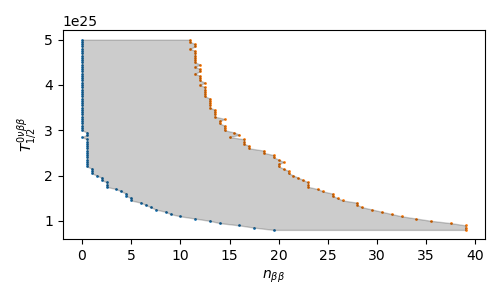

In [9]:
plt.figure(figsize=[5, 3])

plt.scatter(bins[lims[:, 0]], t12s, s=1)
plt.scatter(bins[lims[:, 1]], t12s, s=1)

plt.fill_betweenx(t12s, bins[lims[:, 0]], bins[lims[:, 1]], color="k", alpha=0.2)

# from scipy.interpolate import interp1d
# ll_interp = interp1d(binc[lims[:, 0]], t12s, fill_value="extrapolate")
# ul_interp = interp1d(binc[lims[:, 1]], t12s, fill_value="extrapolate")
# nbbs = np.arange(0, 10, 0.05)
# plt.plot(nbbs, ll_interp(nbbs))
# nbbs = np.arange(0, 40, 1)
# plt.plot(nbbs, ul_interp(nbbs))

plt.xlabel(r"$n_{\beta\beta}$")
plt.ylabel(r"$T^{0\nu\beta\beta}_{1/2}$")
plt.tight_layout()

## Significance

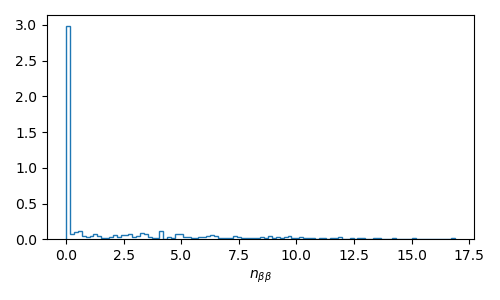

In [12]:
df_ = df[df.nbbt == 0]

plt.figure(figsize=[5, 3])
plt.hist(df_.nbb, bins=100, density=True, histtype="step")
plt.xlabel(r"$n_{\beta\beta}$")
plt.tight_layout();

In [13]:
df.groupby(level=0).nbb.mean()

T12
1.000000e+25    42.937551
1.100000e+25    39.196260
1.200000e+25    36.172047
1.300000e+25    32.840585
1.400000e+25    30.604164
                  ...    
9.600000e+25     5.148895
9.700000e+25     5.108722
9.800000e+25     5.122320
9.900000e+25     5.234928
1.000000e+26     5.210597
Name: nbb, Length: 91, dtype: float64